In [15]:
import numpy as np
import scipy as sp
import scipy.interpolate
import scipy.signal
import skimage as ski
import skimage.color, skimage.filters

import matplotlib.pyplot as plt

from itertools import pairwise

import cv2

#from ImageRectifier import RidgeExtractor, smooth_univariatespline, smooth_pwlf, RowRectifierPwlf
from ImageRectifier import RidgeExtractor, RowRectifierPwlf

## Load image

Load the image

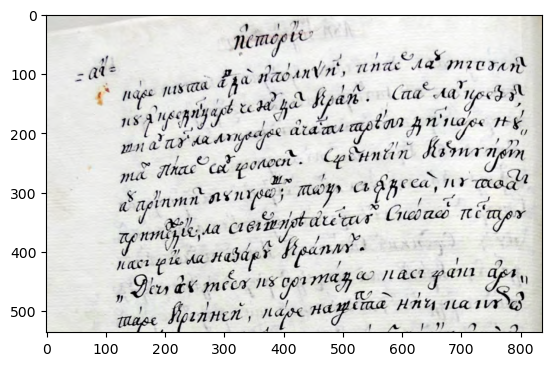

In [16]:
I = plt.imread('Rows.png')
plt.imshow(I)

In [21]:
rr = RowRectifierPwlf(n_segments=4)
rr.fit(I)
Iout = rr.transform(I)


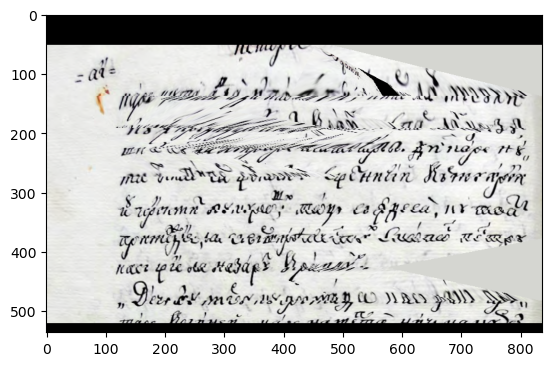

In [19]:
plt.imshow(Iout)

Let's preprocess the image:
1. Convert to grayscale
2. Invert (white writing on black)
3. Filter

In [ ]:
extr = RidgeExtractor()
Ifilt, Iinv, Igray = extr.preprocess_image(I)

plt.imshow(Igray, cmap='gray')
plt.figure()
plt.imshow(Iinv, cmap='gray')
plt.figure()
plt.imshow(Ifilt, cmap='gray')

Below is the kernel used:

In [ ]:
plt.imshow(extr.get_kernel_image(shape=(300,300)), cmap='gray')

## Find ridges

Find some points on a ridge to start ridge extraction from:
1. Select a vertical band in the middle of the page, in order to make sure we catch all the lines, and compute its histogram.
2. Find peaks in the histogram

In [ ]:
fig = extr.get_middleband_peaks_image(Ifilt)

Now let's apply the ridge extraction on the image, starting on the peak points found earlier.

In [ ]:

ridges_ = extr.extract_ridges(Ifilt)

plt.imshow(extr.plot_ridges_on_image(ridges_, I, fg_color=0))

## Spline smoothing

We can smooth and approximate ridges in different ways.

For example we can use splines of degree 1, i.e. approximate as a piecewise linear signal.

In [ ]:
# # Smoothing
# for ridge in ridges:

#     # Limit to part != -1
#     x = np.array(range(I.shape[1]))
#     x_actual = x[ridge != -1]    
#     ridge_actual = ridge[ridge != -1]

#     spl = sp.interpolate.UnivariateSpline(x_actual, ridge_actual, k=1, s=len(x)/2)

#     plt.plot(x_actual, spl(x_actual))

ridges_spl1 = [smooth_univariatespline(ridge) for ridge in ridges_]

plt.imshow(extr.plot_ridges_on_image(ridges_spl1, shape=Ifilt.shape), cmap='gray')

#plt.gca().invert_yaxis()
plt.show()

Zooming on one of the ridges:

In [ ]:
plt.plot(ridges_[1].x, ridges_[1].y)
plt.plot(ridges_spl1[1].x, ridges_spl1[1].y)
plt.gca().invert_yaxis()
plt.show()

## Piecewise linear approximation with fixed number of segments

We can use the Python package `pwfl`. An example on approximating one of the ridges with 4 segments:

In [ ]:
import pwlf 

# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(ridges_[1].x, ridges_[1].y)

# fit the data for N line segments
#res = my_pwlf.fit(10)
res = my_pwlf.fitfast(4, pop=3)

# predict for the determined points
#xHat = np.array(range(x.shape[0]))
yHat = my_pwlf.predict(ridges_[1].x)

plt.plot(ridges_[1].y)
plt.plot(yHat)

plt.gca().invert_yaxis()
plt.show()

## Approximating all ridges with segments

In [ ]:
my_pwlfs = []
knots_all = []
knots_y_all = []
If3 = np.copy(I)

n_segments = 4
n_knots = n_segments + 3

ridges_pwlf = [smooth_pwlf(ridge, n=n_segments, endpoints=[0, I.shape[1]-1]) for ridge in ridges_]


Plot:

In [ ]:

plt.imshow(extr.plot_ridges_on_image(ridges_pwlf, I, line=True), cmap='gray')
# plt.figure()
# plt.imshow(If3, cmap='gray')
# #plt.gca().invert_yaxis()
# plt.show()

Plot grid

In [ ]:
plt.imshow(If3, cmap='gray')

for k in range(len(knots_all)-1):
    for i in range(len(knots_all[0]-1)):
        #plt.plot([knots_y_all[k][i], knots_y_all[k+1][i]],[knots_all[k][i], knots_all[k+1][i]])
        plt.plot([knots_all[k][i], knots_all[k+1][i]],[knots_y_all[k][i], knots_y_all[k+1][i]])
        #print([knots_all[k][i], knots_all[k+1][i]])
        #print([knots_y_all[k][i], knots_y_all[k+1][i]])
        
plt.show()

In [ ]:
# Compute target coordinates
# Horizontal line
target_knots_y_all = [[knots_y[0]]*len(knots_y)  for knots_y in knots_y_all]

# According to lengths
ridge_length = []
for xs, ys in zip(knots_all, knots_y_all):
     ridge_length.append(sum([np.linalg.norm(np.array(p2)-np.array(p1)) for p1, p2 in pairwise(zip(xs, ys))]))
#ridge_length

ridge_cum_length = []
for xs, ys in zip(knots_all, knots_y_all):
     # Prepend 0, gets lots because of pairwise()
     ridge_cum_length.append(np.cumsum([0] + [np.linalg.norm(np.array(p2)-np.array(p1)) for p1, p2 in pairwise(zip(xs, ys))]))
#ridge_cum_length 

target_length = I.shape[1]
target_knots_x_all = [cumlen / totallen * target_length for cumlen,totallen in zip(ridge_cum_length, ridge_length)]
#target_knots_x_all



In [ ]:
If4 = np.copy(I)
plt.imshow(If4, cmap='gray')

for k in range(len(target_knots_x_all)-1):
    plt.plot([0, If4.shape[1]],[target_knots_y_all[k][0], target_knots_y_all[k][0]], 'k')
    for i in range(len(target_knots_x_all[0]-1)):
        #plt.plot([knots_y_all[k][i], knots_y_all[k+1][i]],[knots_all[k][i], knots_all[k+1][i]])
        plt.plot([target_knots_x_all[k][i], target_knots_x_all[k+1][i]],[target_knots_y_all[k][i], target_knots_y_all[k+1][i]])
        #print([knots_all[k][i], knots_all[k+1][i]])
        #print([knots_y_all[k][i], knots_y_all[k+1][i]])
        
plt.show()

## Rectify

Compute target points for all rectangles defined by the knots

TODO

In [ ]:
# Rectify a box
def rect_box_image(points_src, points_dst, Iold):

    Inew = Iold.copy()

    persp_mat = cv2.getPerspectiveTransform(points_src, points_dst, cv2.DECOMP_LU)
    Ipersp = cv2.warpPerspective(Iold, persp_mat, Inew.shape[1::-1], flags=cv2.INTER_LINEAR)

    return Ipersp    


In [ ]:
# for (itop, top), (ibottom, bottom) in pairwise(enumerate(target_knots_x_all)):
#     for topleft, topright in pairwise()
self.polys_dst_ = []
for k in range(len(target_knots_x_all)-1):
    # toprow_pairs = pairwise(target_knots_x_all[k])
    # botrow_pairs = pairwise(target_knots_x_all[k+1])
    #for top_left, top_right in pairwise(target_knots_x_all[k])
    for i in range(len(target_knots_x_all[0])-1):
        x_top_left  = target_knots_x_all[k][i]
        x_top_right = target_knots_x_all[k][i+1]
        x_bot_left  = target_knots_x_all[k+1][i]
        x_bot_right = target_knots_x_all[k+1][i+1]

        y_top_left  = target_knots_y_all[k][i]
        y_top_right = target_knots_y_all[k][i+1]
        y_bot_left  = target_knots_y_all[k+1][i]
        y_bot_right = target_knots_y_all[k+1][i+1]

        # Pair coordinates
        self.polys_dst_.append([ [x_top_left, y_top_left], [x_top_right, y_top_right], [x_bot_right, y_bot_right], [x_bot_left, y_bot_left]])

source_boxes = []
for k in range(len(knots_all)-1):
    # toprow_pairs = pairwise(target_knots_x_all[k])
    # botrow_pairs = pairwise(target_knots_x_all[k+1])
    #for top_left, top_right in pairwise(target_knots_x_all[k])
    for i in range(len(knots_all[0])-1):
        x_top_left  = knots_all[k][i]
        x_top_right = knots_all[k][i+1]
        x_bot_left  = knots_all[k+1][i]
        x_bot_right = knots_all[k+1][i+1]

        y_top_left  = knots_y_all[k][i]
        y_top_right = knots_y_all[k][i+1]
        y_bot_left  = knots_y_all[k+1][i]
        y_bot_right = knots_y_all[k+1][i+1]

        # Pair coordinates
        source_boxes.append([ [x_top_left, y_top_left], [x_top_right, y_top_right], [x_bot_right, y_bot_right], [x_bot_left, y_bot_left] ])


In [ ]:
# Prepare new matrix
I5 = np.zeros_like(I)

for src_box, dst_box in zip(source_boxes, self.polys_dst_):
    Iwarped = rect_box_image(np.array(src_box, dtype = "float32"), np.array(dst_box, dtype = "float32"), I) 
        
    # Create mask for the triangle we want to transform
    # mask = np.zeros(dst_img_cropped.shape, dtype = np.uint8)
    # cv2.fillConvexPoly(mask, np.int32(dst_triangle_cropped), (1.0, 1.0, 1.0), 16, 0);

    # # Delete all existing pixels at given mask
    # dst_img_cropped*=1-mask
    # # Add new pixels to masked area
    # dst_img_cropped+=dst_img_warped*mask    

    mask = np.zeros_like(Iwarped, dtype=np.uint8)
    cv2.fillConvexPoly(mask, np.int32(dst_box), (1.0, 1.0, 1.0), 16, 0);

    # Delete all existing pixels at given mask
    I5*=1-mask
    # Add new pixels to masked area
    I5+=Iwarped*mask    

plt.imshow(I5, cmap='gray')
plt.show()

In [ ]:
len(target_knots_x_all)
target_knots_x_all[0]
#target_knots_y_all[0]

In [ ]:
source_boxes[0]



In [ ]:
source_boxes[1]